# NLP PROJECT

In [760]:
# Import required libraries

# Data loading and manipulation
import pandas as pd
import numpy as np

# Text preprocessing and NLP
import nltk
import re 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)



# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.colors as pc
from IPython.display import Image, display
from PIL import Image, ImageDraw, ImageFont

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


# Model evaluation metrics
from sklearn.metrics import classification_report,accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score



# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set(style="whitegrid")
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

steps:
1. Business understanding
2. Business problem
3. data understanding
4. Text preprocessing
5. Data cleaning & EDA
6. vectorization
7. Modeling & iteration
8. Interpratability

### Data inspection

In [761]:

Movie_Lens=pd.read_csv("..\Data\judge-1377884607_tweet_product_company.csv",
                       encoding='ISO-8859-1') 
#'ISO-8859-1'-ensures no decoding error is thrown since dataset contains 
# non-UTF-8 characters commonly found on social media texts


In [762]:
#DISPLAY FIRST FEW ROWS
Movie_Lens.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [763]:
Movie_Lens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [764]:
Movie_Lens.shape

(9093, 3)

In [765]:
Movie_Lens.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [766]:
#check for missing values
Movie_Lens.isna().sum().sort_index(ascending=True)

emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
tweet_text                                               1
dtype: int64

In [767]:
#sort percentage of missing values and display data types
(Movie_Lens.isna().mean() * 100).sort_values(ascending=False).to_frame(
    name='Percentage_missing').assign(Dtype=Movie_Lens.dtypes).style.bar(
        subset=['Percentage_missing'], color="red")

,Percentage_missing,Dtype
emotion_in_tweet_is_directed_at,63.807324,object
tweet_text,0.010997,object
is_there_an_emotion_directed_at_a_brand_or_product,0.000000,object


In [768]:
#check for duplicates
Movie_Lens.duplicated().sum()

22

From Data exploration, we observe:
1. the data contains 9093 rows and 3 columns.The column names are:  
  - tweet_text
  - emotion_in_tweet_is_directed_at
  - is_there_an_emotion_directed_at_a_brand_or_product 
2. Some columns have large missing values and some of the information is duplicated
3. 


### DATACLEANING
steps taken:
 1. Change column names to make it easy to read and remove duplicates to avoid skewness.
 
 2. remove missing values for the `tweet_text` column since it has only one missing value and misleading for our analysis to impute the missing tweet

 3. Remove duplicates to prevent Data Leakage. if duplicates remain they may cause accuracy ti spike later as the model already "saw" the answer while training

 4. For the `emotion_in_tweet_is_directed_at` column that has almost 64% missing values, we will assume the "NaN" might mean general experience rather than experience with a specific hardware device hence we fill with a placeholder "General" or choose to drop the column completely

 5.

 
 

In [769]:
#rename columns
Movie_Lens.columns = ['tweet', 'product', 'sentiment']

Movie_Lens.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [770]:
#drop duplicates
Movie_Lens.drop_duplicates(inplace=True)

#recheck if dropped
Movie_Lens.duplicated().sum()

0

In [771]:
# remove missing values for `tweet_text`
Movie_Lens.dropna(subset=['tweet'],inplace=True)

In [772]:
#confirm if dropped
Movie_Lens['tweet'].isna().sum()


0

In [773]:
#impute  "General" to `emotion_in_tweet_is_directed_at` column
Movie_Lens['product'].fillna("General",inplace=True)


#verify if filled
Movie_Lens['product'].isna().sum()

0

## Exploratory Data Analysis

we need to understand our text data by asking:
1. What products have the most reviews/customer interaction ? 

2. Target Class structure and imbalance(how the sentiments are distributed across the dataset)

3. Does number of words or length of tweet in text determine if tweet is positive or negative?(are negative or positive tweets more expressive?)

4. What makes tweets positive vs negative?(common words in positive or negative tweets)(Vocabulary use)


6. Feature-target relationship (correlation and linearity)

### 1. What products have the most reviews/customer interaction ? 

In [774]:
(
    Movie_Lens['product']
    .value_counts()
    .to_frame(name="count")
    .assign(
        class_percentage=lambda x: (x['count'] / x['count'].sum()) * 100
    )
    .sort_values(by="class_percentage", ascending=False)
    .style
    .bar(subset=["class_percentage"], color='red')
    .format({
        "class_percentage": "{:.2f}%"
    })
)

,count,class_percentage
product,,
General,5788,63.81%
iPad,945,10.42%
Apple,659,7.27%
iPad or iPhone App,469,5.17%
Google,428,4.72%
iPhone,296,3.26%
Other Google product or service,293,3.23%
Android App,80,0.88%
Android,77,0.85%


In [775]:
# Analyzing product mentions (excluding 'Unknown')
product_sentiment = pd.crosstab(Movie_Lens['product'], 
                                Movie_Lens['sentiment'])

top_products = Movie_Lens['product'].value_counts().head(10)

print("Top 10 Most Mentioned Products:")
print(" "*2)
print(top_products)

Top 10 Most Mentioned Products:
  
product
General                            5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: count, dtype: int64


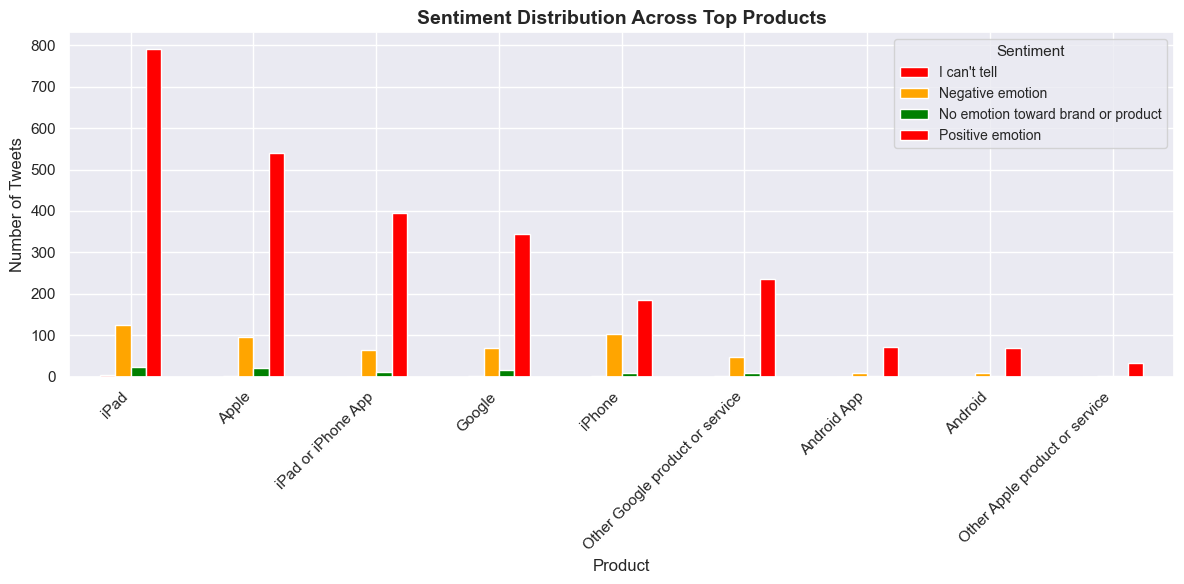

In [776]:
# Visualizing sentiment distribution for top products
top_product_names = top_products.index.tolist()
if 'General' in top_product_names:
    top_product_names.remove('General')
    top_product_names = top_product_names[:9]
else:
    top_product_names = top_product_names[:9]

product_sentiment_filtered = product_sentiment.loc[top_product_names]

fig, ax = plt.subplots(figsize=(12, 6))
product_sentiment_filtered.plot(kind='bar', stacked=False, ax=ax, 
                                color=['red', 'orange', 'green'])
ax.set_title('Sentiment Distribution Across Top Products',
              fontsize=14, fontweight='bold')
ax.set_xlabel('Product', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.legend(title='Sentiment', title_fontsize=11, fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The "General" product class category accounts for majority of observations, while brand-specific product classes are underrepresented. This may bias classification toward majority class and should be addressed during modeling.

### 2. Target Class structure and imbalance(how the sentiments are distributed across the dataset)

In [777]:
#check for class imbalance and sort percentage in descending

(
    Movie_Lens['sentiment']
    .value_counts()
    .to_frame(name="count")
    .assign(
        class_percentage=lambda x: (x['count'] / x['count'].sum()) * 100
    )
    .sort_values(by="class_percentage", ascending=False)
    .style
    .bar(subset=["class_percentage"], color='red')
    .format({
        "class_percentage": "{:.2f}%"
    })
)


,count,class_percentage
sentiment,,
No emotion toward brand or product,5375,59.26%
Positive emotion,2970,32.75%
Negative emotion,569,6.27%
I can't tell,156,1.72%


The sentiments are quite imbalanced with **no emotion towards brand** being the highest class and **i can't tell** being the lowest class. Theres also need to combine the two emotions as **neutral** and keep the rest as **positive** and  **negative**. 

In [778]:
#combine 'No emotion toward brand or product' and 'I can't tell' into one emotion named "Neutral"
Movie_Lens['sentiment']=Movie_Lens['sentiment'].replace({
    "No emotion toward brand or product": "Neutral",
    "I can't tell": "Neutral",
    "Positive emotion": "Positive",
    "Negative emotion" : "Negative"
})

#new class percentages
(
    Movie_Lens['sentiment']
    .value_counts()
    .to_frame(name="count")
    .assign(
        class_percentage=lambda x: (x['count'] / x['count'].sum()) * 100
    )
    .sort_values(by="class_percentage", ascending=False)
    .style
    .bar(subset=["class_percentage"], color='red')
    .format({
        "class_percentage": "{:.2f}%"
    })
)

,count,class_percentage
sentiment,,
Neutral,5531,60.98%
Positive,2970,32.75%
Negative,569,6.27%


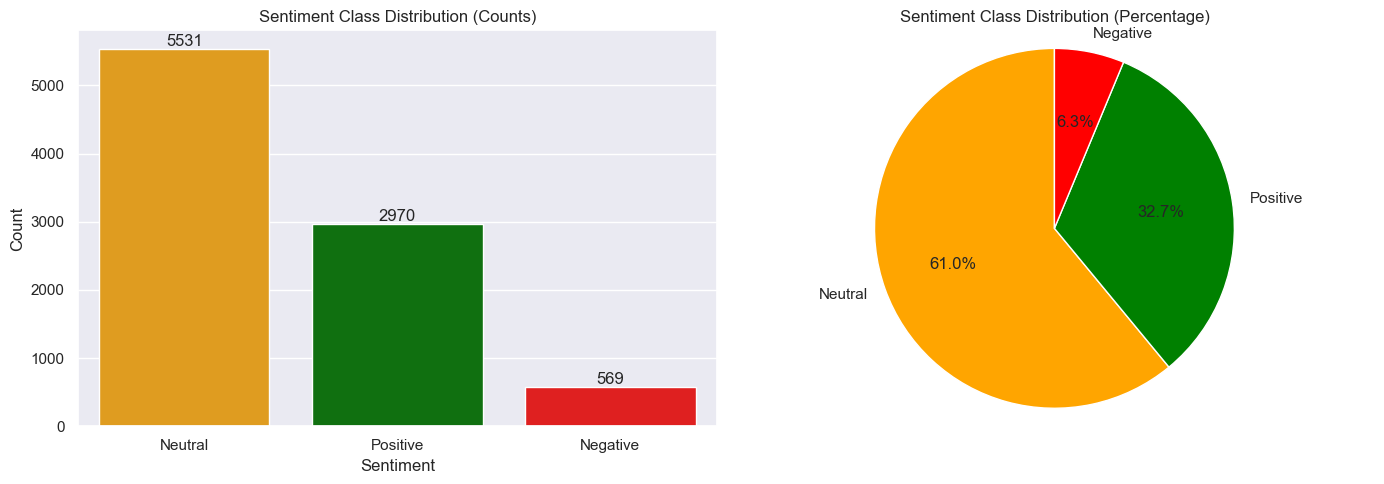

In [779]:

# Prepare data
counts = Movie_Lens['sentiment'].value_counts()
percentages = counts / counts.sum() * 100

# Fixed color mapping for consistency
color_map = {
    'Positive': 'green',
    'Negative': 'red',
    'Neutral': 'orange'
}

# Ensure colors follow class order
colors = [color_map[label] for label in counts.index]

# Create figure
plt.figure(figsize=(14, 5))

# ---- Bar Chart (Counts) ----
plt.subplot(1, 2, 1)
sns.barplot(
    x=counts.index,
    y=counts.values,
    palette=colors
)
plt.title("Sentiment Class Distribution (Counts)")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# Add count labels
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

# ---- Pie Chart (Percentages) ----
plt.subplot(1, 2, 2)
plt.pie(
    percentages.values,
    labels=percentages.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
plt.title("Sentiment Class Distribution (Percentage)")
plt.axis('equal')

plt.tight_layout()
plt.show()


The dataset shows class imbalance, with neutral Tweets occurring more frequently than positive or negative ones. This imbalance is considered when evaluating model performance.


### 3. Does number of words or length of tweet in text determine if tweet is positive or negative?(are negative or positive tweets more expressive?)

In [780]:
#add new column "Tweet_length" and "word_count"
Movie_Lens['tweet_length']=Movie_Lens['tweet'].astype(str).apply(len)
Movie_Lens['word_count']=Movie_Lens['tweet'].astype(str).apply(lambda x: len(x.split()))


#check new shape
Movie_Lens.head()

,tweet,product,sentiment,tweet_length,word_count
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,127,23
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,139,22
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,79,15
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,82,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,131,17


In [781]:
length_by_sentiment=Movie_Lens.groupby("sentiment")[['tweet_length','word_count']
                                                    ].agg(['mean','median'])


print("Tweet Characters by sentiment")
print(" " *6)
print(length_by_sentiment.round(2))


Tweet Characters by sentiment
      
          tweet_length        word_count       
                  mean median       mean median
sentiment                                      
Negative        109.41  114.0      18.75   19.0
Neutral         104.18  108.0      17.44   18.0
Positive        105.55  110.0      18.18   19.0


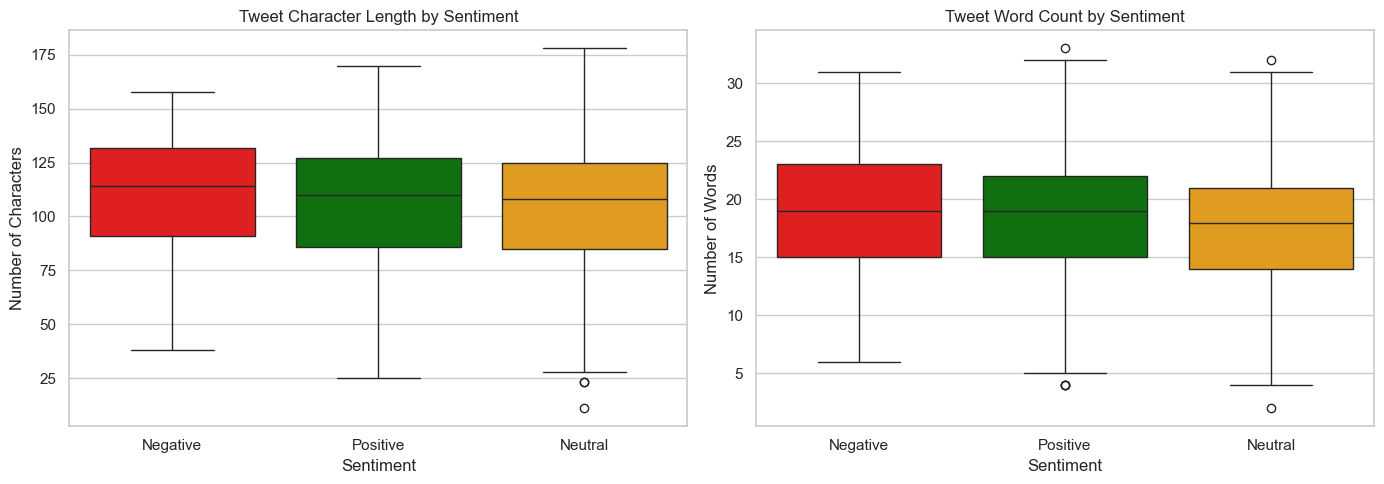

In [782]:
#visualize
# Set style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(14, 5))

# ---- Tweet Length by Sentiment ----
plt.subplot(1, 2, 1)
sns.boxplot(
    data=Movie_Lens,
    x='sentiment',
    y='tweet_length',
    palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'orange'}
)
plt.title("Tweet Character Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Characters")

# ---- Word Count by Sentiment ----
plt.subplot(1, 2, 2)
sns.boxplot(
    data=Movie_Lens,
    x='sentiment',
    y='word_count',
    palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'orange'}
)
plt.title("Tweet Word Count by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")

plt.tight_layout()
plt.show()



The analysis show their medians are relatively close yet Interquartile ranges overlap heavily. Although Negative tweets appear slightly lengthy compared to the others , their difference is small and inconsistent hence tweet length alone does not separate positive or negative sentiments.

For word counts, neutral tweets tend to be slightly shorter but the diffrence is unreliable. Outliers exist in all classes showing extreme word counts occur regardless of sentiment.




### 4. What makes tweets positive vs negative?(common words in positive or negative tweets)(Vocabulary use)

In [783]:
#Dropped the columns that were created for Analysis

Movie_Lens=Movie_Lens.drop(['tweet_length','word_count'],axis=1)

### 5. Feature-target relationship (correlation and linearity)

## TEXT PREPROCESSING FOR NLP

Raw Tweets contain noise such as URLs, mentions, hashtags, punctuation, and inconsistent casing.
To prepare the text for modeling, the following preprocessing steps were applied:

 - Converted text to lowercase
 - Removed URLs, mentions (@user), and hashtags
 - Removed punctuation and numbers
 - Tokenized the text
 - Removed stopwords
 - Applied TF-IDF vectorization to convert text into numerical features

### LOWERCASING

In [784]:
# function to lowercase text
def to_lowercase(text):
    return text.lower()

Movie_Lens['tweet']=Movie_Lens['tweet'].apply(to_lowercase)
Movie_Lens.head()

,tweet,product,sentiment
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive


### Remove Punctuations

In [785]:
import string

def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

Movie_Lens['tweet']=Movie_Lens['tweet'].apply(remove_punctuation)
Movie_Lens.head()

,tweet,product,sentiment
0,wesley83 i have a 3g iphone after 3 hrs tweeti...,iPhone,Negative
1,jessedee know about fludapp awesome ipadiphon...,iPad or iPhone App,Positive
2,swonderlin can not wait for ipad 2 also they s...,iPad,Positive
3,sxsw i hope this years festival isnt as crashy...,iPad or iPhone App,Negative
4,sxtxstate great stuff on fri sxsw marissa maye...,Google,Positive


### remove stopwords


In [786]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def remove_stopword(text):
    return " ".join([word for word in text.split() if word not in 
                     ENGLISH_STOP_WORDS])


Movie_Lens['tweet']=Movie_Lens['tweet'].apply(remove_stopword)
Movie_Lens.head()

,tweet,product,sentiment
0,wesley83 3g iphone 3 hrs tweeting riseaustin d...,iPhone,Negative
1,jessedee know fludapp awesome ipadiphone app y...,iPad or iPhone App,Positive
2,swonderlin wait ipad 2 sale sxsw,iPad,Positive
3,sxsw hope years festival isnt crashy years iph...,iPad or iPhone App,Negative
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive


### LEMMATIZATION

In [787]:
lemmatizer=WordNetLemmatizer()

def lemmatization_of_text(text):
    tokens=word_tokenize(text)
    lemmatized=[lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized)


Movie_Lens['tweet']=Movie_Lens['tweet'].apply(lemmatization_of_text)

Movie_Lens['tweet']


0       wesley83 3g iphone 3 hr tweeting riseaustin de...
1       jessedee know fludapp awesome ipadiphone app y...
2                        swonderlin wait ipad 2 sale sxsw
3       sxsw hope year festival isnt crashy year iphon...
4       sxtxstate great stuff fri sxsw marissa mayer g...
                              ...                        
9088                                       ipad sxsw link
9089    wave buzz rt mention interrupt regularly sched...
9090    google zeiger physician reported potential ae ...
9091    verizon iphone customer complained time fell h...
9092    ï¡ïàüêîò£áââ£âûârt ment...
Name: tweet, Length: 9070, dtype: object

In [788]:
Movie_Lens.head()

,tweet,product,sentiment
0,wesley83 3g iphone 3 hr tweeting riseaustin de...,iPhone,Negative
1,jessedee know fludapp awesome ipadiphone app y...,iPad or iPhone App,Positive
2,swonderlin wait ipad 2 sale sxsw,iPad,Positive
3,sxsw hope year festival isnt crashy year iphon...,iPad or iPhone App,Negative
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive


In [789]:
Movie_Lens.columns

Index(['tweet', 'product', 'sentiment'], dtype='object')

## WORDCLOUD:


In [ ]:
from wordcloud import WordCloud


def create_wordcloud(sentiment_label, title, df):
    subset = df[df['sentiment'] == sentiment_label]

    print(f"{title} | Tweets found: {len(subset)}")

    if subset.empty:
        print("❌ No tweets found — check sentiment label")
        return
     
    
    text = f"{sentiment_label}"+" ".join(subset['tweet'].dropna().astype(str))


    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='PiYG',
        stopwords='english',
        max_words=200,
        max_font_size=120,
        relative_scaling=0,
        contour_color="white",
        contour_width=3
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [791]:
Movie_Lens['sentiment'].unique()


array(['Negative', 'Positive', 'Neutral'], dtype=object)

Most Common Words in Positive Tweets | Tweets found: 2970


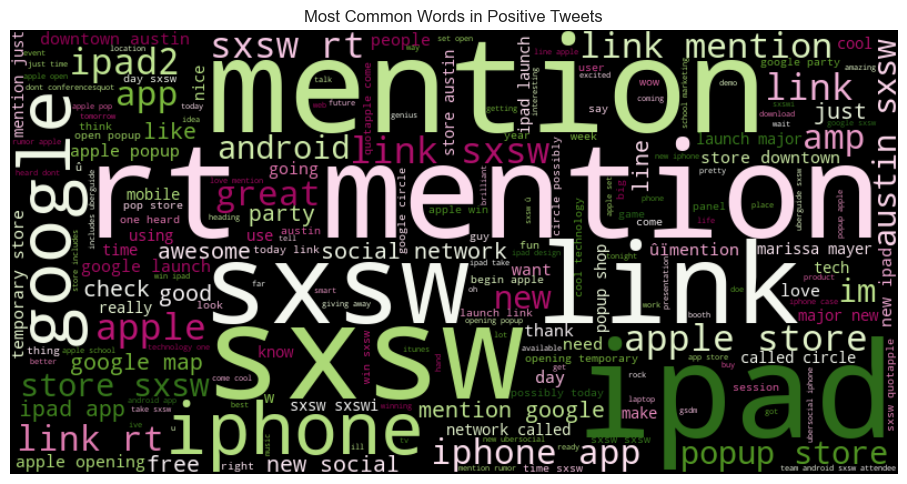

Most Common Words in Negative Tweets | Tweets found: 569


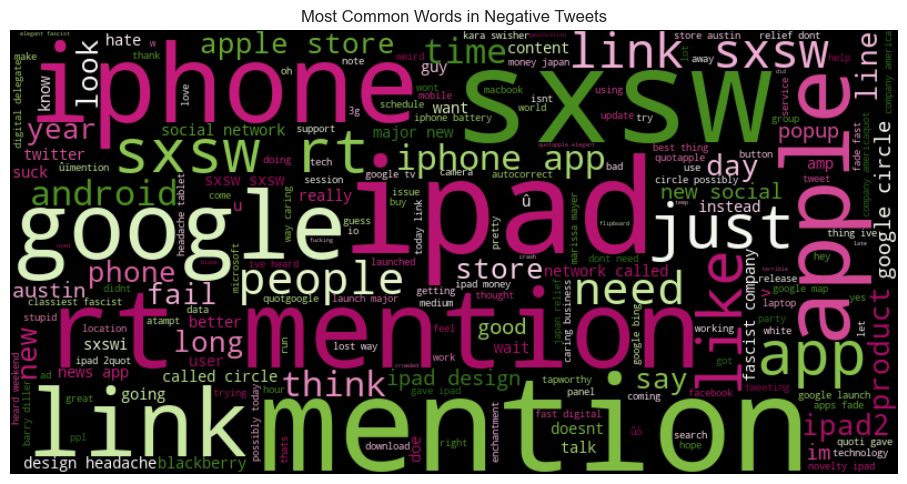

In [792]:
create_wordcloud(
    sentiment_label='Positive',
    title='Most Common Words in Positive Tweets',
    df=Movie_Lens
)

create_wordcloud(
    sentiment_label='Negative',
    title='Most Common Words in Negative Tweets',
    df=Movie_Lens
)


## Split data into features and Target

In [793]:
X=Movie_Lens['tweet']
y=Movie_Lens['sentiment']

In [794]:
print(type(X),X.shape)

print(type(y), y.shape)

<class 'pandas.core.series.Series'> (9070,)
<class 'pandas.core.series.Series'> (9070,)


## Train test split

In [795]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,random_state=42,stratify=y)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(7256,) (7256,) (1814,) (1814,)


In [796]:
#train and test dataset summary
print("Dataset split summary:")
print("     ")
print(f"Training set: {X_train.shape[0]:6,} , samples: ({X_train.shape[0]/len(X)*100:.1f}%)")
print("     ")
print(f"Testing set:  {X_test.shape[0]:6,}  , samples: ({X_test.shape[0]/len(X)*100:.1f}%)")



Dataset split summary:
     
Training set:  7,256 , samples: (80.0%)
     
Testing set:   1,814  , samples: (20.0%)


## MODEL EVALUATION


Accuracy alone is not sufficient for evaluating sentiment models, especially with class imbalance.

For this business problem:
- **Recall for negative sentiment** is important because failing to detect negative Tweets may cause businesses to miss customer complaints.
- **Precision** helps avoid mislabeling neutral Tweets as negative, which could lead to unnecessary concern.
- **F1-score** provides a balance between precision and recall across all classes.

Therefore, the model is evaluated using:
- Precision, Recall, and F1-score
- Confusion Matrix




## Baseline Model: Multinomial Naive bayes

its good for multiclass....

In [797]:
# Create baseline pipeline


baseline_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,  # Limit vocabulary size
        min_df=2,           # Ignore very rare words
        ngram_range=(1, 1)  # Only unigrams for baseline
    )),
    ('classifier', MultinomialNB())
])

# Train the model
baseline_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_baseline = baseline_pipeline.predict(X_test)

**BASELINE MODEL PERFORMANCE**
_________________________________________________

Accuracy: 0.6626
_________________________________________________

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.01      0.02       114
     Neutral       0.66      0.93      0.77      1106
    Positive       0.65      0.30      0.41       594

    accuracy                           0.66      1814
   macro avg       0.61      0.41      0.40      1814
weighted avg       0.65      0.66      0.61      1814

_________________________________________________


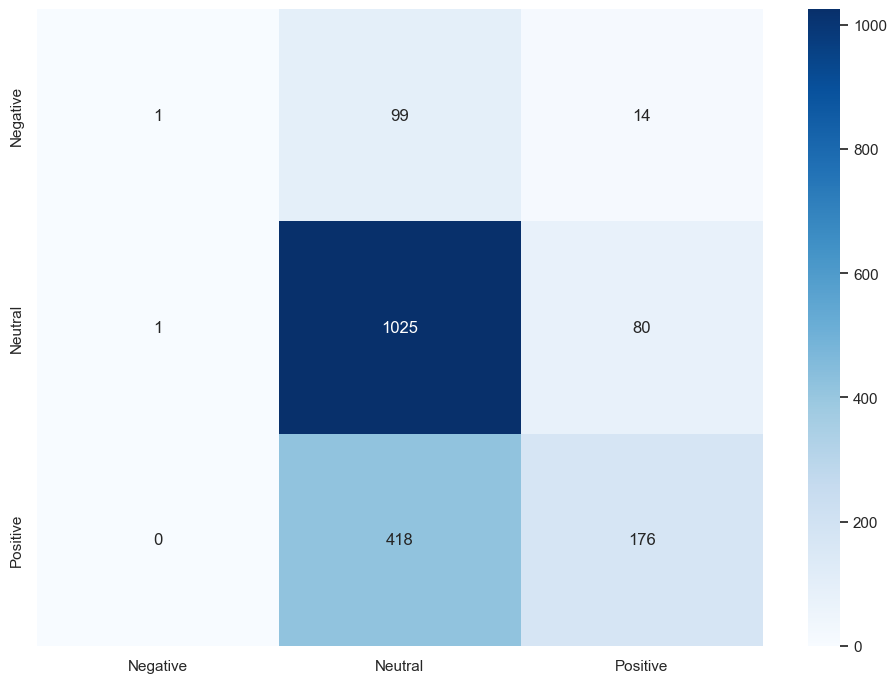

In [798]:
# Evaluating the model
print("**BASELINE MODEL PERFORMANCE**")

print("_________________________________________________")

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")

print("_________________________________________________")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

print("_________________________________________________")

#confusion matrix
CM=confusion_matrix(y_test,y_pred_baseline)

sns.heatmap(CM,annot=True,fmt='d',cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])

plt.show()

“Although the model achieved an accuracy of 84%, this performance is misleading due to class imbalance. The classifier heavily favored the positive class, resulting in very poor recall for negative tweets. This indicates the model is not effectively identifying negative sentiment.”


For the business, this means:

    -Customer complaints are being ignored

    -Brand risk is hidden

    -Accuracy looks good, but the model is failing its main purpose

In [799]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'alpha': [0.01, 0.1, 0.5, 1.0]
# }

# nb = MultinomialNB()
# grid = GridSearchCV(
#     nb,
#     param_grid,
#     scoring='f1_macro',
#     cv=5
# )

# grid.fit(X_train_vect, y_train)

# best_nb = grid.best_estimator_
